In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import os

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import numpy as np

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source

import time

from package.helpers import test_lens
from package.plots import plot, diagnostic_plot

In [3]:
oversample_factor_list = [1, 3]
execution_time = []

figure_dir = os.path.join(repo_path, 'figures', 'diagnostics', 'pixel_density_test')
array_dir = os.path.join(repo_path, 'output', 'arrays', 'diagnostics', 'pixel_density_test')

lens = test_lens.TestLens()

In [10]:
for oversample_factor in tqdm(oversample_factor_list):
    side = 5
    num_pix = 45 * oversample_factor

    image = lens.get_array(num_pix, side)

    plot.plot(filepath=os.path.join(figure_dir, f'model_{oversample_factor}.png'),
              title=f'Lenstronomy model\nOversampling factor {oversample_factor}', 
              array=image,
              colorbar=True)
    np.save(os.path.join(array_dir, f'model_{oversample_factor}'), image)

    # start timer
    start = time.time()

    calc = build_default_calc('roman', 'wfi', 'imaging')

    # scene size settings
    calc['configuration']['dynamic_scene'] = True
    calc['configuration']['max_scene_size'] = 5

    # change filter
    calc['configuration']['instrument']['filter'] = 'f106'

    # normalize (np.interp for now)
    max = np.max(image)
    min = np.min(image)
    image = np.interp(image, (min, max), (0.00001, 0.001))

    i = 0
    print('Converting to point sources...')
    for row_number, row in tqdm(enumerate(image)):
        for item_number, item in enumerate(row):
            if i != 0:
                calc['scene'].append(build_default_source(geometry="point"))
            calc['scene'][i]['position']['x_offset'] = (item_number * (1 / 9) * (
                        1 / oversample_factor)) + lens.ra_at_xy_0  # arcsec
            calc['scene'][i]['position']['y_offset'] = (row_number * (1 / 9) * (
                        1 / oversample_factor)) + lens.dec_at_xy_0  # arcsec
            calc['scene'][i]['spectrum']['normalization']['norm_flux'] = item

            i += 1
    print('Point source conversion complete')

    print('Performing Pandeia calculation...')
    results = perform_calculation(calc)
    print('Pandeia calculation complete')

    # stop timer
    stop = time.time()
    execution_time.append(stop - start)

    detector = results['2d']['detector']

    # TODO TEMP! flip image
    detector = np.flipud(detector)
    # detector = np.fliplr(detector)

    plot.plot(filepath=os.path.join(figure_dir, f'pandeia_{oversample_factor}.png'),
              title=f'Pandeia simulation\nOversampling factor {oversample_factor}', 
              array=detector,
              colorbar=True)

    # save this numpy array
    np.save(os.path.join(array_dir, f'detector_{oversample_factor}'), detector)

  0%|          | 0/2 [00:00<?, ?it/s]

Converting to point sources...


45it [00:10,  4.39it/s]


Point source conversion complete
Performing Pandeia calculation...


Pandeia calculation complete


 50%|█████     | 1/2 [03:07<03:07, 187.42s/it]

Converting to point sources...


135it [01:31,  1.47it/s]


Point source conversion complete
Performing Pandeia calculation...


Pandeia calculation complete


100%|██████████| 2/2 [31:03<00:00, 931.53s/it] 


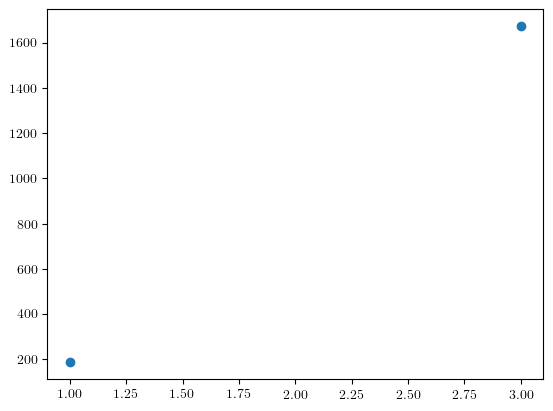

In [11]:
plt.scatter(oversample_factor_list, execution_time)
plt.show()

In [4]:
one = np.load(os.path.join(array_dir, 'detector_1.npy'))
three = np.load(os.path.join(array_dir, 'detector_3.npy'))

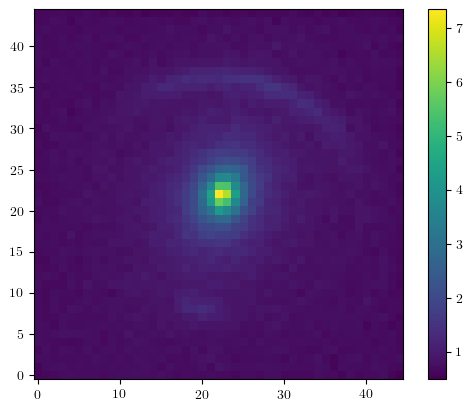

In [5]:
plot.plot(None, None, one, colorbar=True)

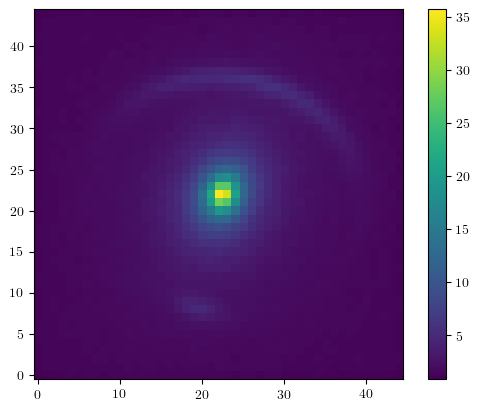

In [6]:
plot.plot(None, None, three, colorbar=True)

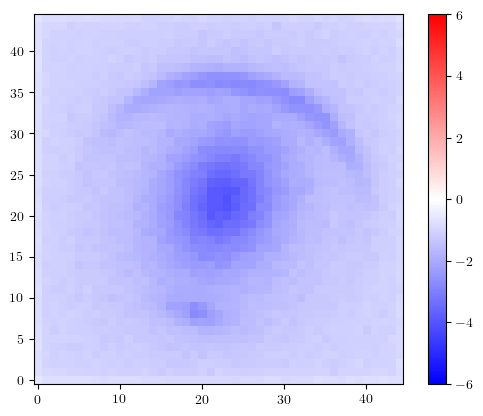

In [7]:
diagnostic_plot.residual(None, None, one, three)